In this notebook we will study the energy conservation properties of several high-order methods for a system with the following Hamiltonian:
$$
\mathcal{H}\left(q_0,q_2,p_0,p_2\right) = \frac{A}{2} \left(p_0^2 + p_2^2 + q_0^2 + q_2^2\right) + \frac{B}{\sqrt{2}} q_0 \left(3q_2^2 - q_0^2\right) + \frac{D}{4} \left(q_0^2+q_2^2\right)^2
$$
This Hamiltonian resembles the Hénon-Heiles one, but it has an additional fourth order term.
The aim of this benchmark is to see what happens with the energy error when highly accurate solutions are needed and how the results compare with the Hénon-Heiles case.

In [1]:
using DifferentialEquations, Plots
using TaylorIntegration
pyplot()

T(p) = A / 2 * norm(p)^2
V(q) = A / 2 * (q[1]^2 + q[2]^2) + B / √2 * q[1] * (3 * q[2]^2 - q[1]^2) + D / 4 * (q[1]^2 + q[2]^2)^2
H(p, q, params) = T(p) + V(q)

const A, B, D = 1., 0.55, 0.4

module InPlace
using ParameterizedFunctions

function q̇(dq, p, q, params, t)
    dq[1] = A * p[1]
    dq[2] = A * p[2]
end

function ṗ(dp, p, q, params, t)
    dp[1] = -A * q[1] - 3 * B / √2 * (q[2]^2 - q[1]^2) - D * q[1] * (q[1]^2 + q[2]^2)
    dp[2] = -q[2] * (A + 3 * √2 * B * q[1] + D * (q[1]^2 + q[2]^2))
end

const A, B, D = 1., 0.55, 0.4

const q0 = [4.919080920016389, 2.836942666663649]
const p0 = [0., 0.]
const u0 = vcat(q0, p0)

h_eqs = @ode_def HamiltEqs begin
  dp₀ = -A * q₀ - 3 * B / √2 * (q₂^2 - q₀^2) - D * q₀ * (q₀^2 + q₂^2)
  dp₂ = -q₂ * (A + 3 * √2 * B * q₀ + D * (q₀^2 + q₂^2))
  dq₀ = A * p₀
  dq₂ = A * p₂
end A B D

p = [1.0,0.55,0.4]

end

module OutOfPlace
using StaticArrays

function q̇(p, q, params, t)
    p
end

function ṗ(p, q, params, t)
    dp1 = -A * q[1] - 3 * B / √2 * (q[2]^2 - q[1]^2) - D * q[1] * (q[1]^2 + q[2]^2)
    dp2 = -q[2] * (A + 3 * √2 * B * q[1] + D * (q[1]^2 + q[2]^2))
    @SVector [dp1, dp2]
end

const A, B, D = 1., 0.55, 0.4

const q0 = @SVector [4.919080920016389, 2.836942666663649]
const p0 = @SVector [0., 0.]
const u0 = vcat(p0,q0)

h_eqs(z, params, t) = SVector(
    -A * z[3] - 3 * B / √2 * (z[4]^2 - z[3]^2) - D * z[3] * (z[3]^2 + z[4]^2), 
    -z[4] * (A + 3 * √2 * B * z[3] + D * (z[3]^2 + z[4]^2)),
    z[1],
    z[2]
)

p = nothing

end

function g(resid,u)
    resid[1] = H([u[1],u[2]],[u[3],u[4]],nothing) - E
    resid[2:4] .= 0
end

const cb = ManifoldProjection(g, nlopts=Dict(:ftol=>1e-13))

const E = H(InPlace.q0, InPlace.p0)

119.99999999999999

For the comparison we will use the following function

In [2]:
energy_err(sol) = map(i->H([sol[1,i], sol[2,i]], [sol[3,i], sol[4,i]],nothing),-E, 1:length(sol.u))
abs_energy_err(sol) = [abs.(H([sol[1,j], sol[2,j]], [sol[3,j], sol[4,j]],nothing) - E) for j=1:length(sol.u)]

function compare(mode=InPlace, all=true, plt=nothing; tmax=1e2)
    prob1 = DynamicalODEProblem(mode.ṗ,  mode.q̇, mode.p0, mode.q0, (0., tmax))
    prob2 = ODEProblem(mode.h_eqs, mode.u0, (0., tmax), mode.p)

    gc()
    (mode == InPlace  && all) && @time sol1 = solve(prob2, Vern9(), callback=cb, abstol=1e-14, reltol=1e-14)
    gc()
    @time sol2 = solve(prob1, KahanLi8(), dt=1e-2, maxiters=1e10)
    gc()
    @time sol3 = solve(prob1, SofSpa10(), dt=1e-2, maxiters=1e8)
    gc()
    @time sol4 = solve(prob2, Vern9(), abstol=1e-14, reltol=1e-14)
    gc()
    @time sol5 = solve(prob1, DPRKN12(), abstol=1e-14, reltol=1e-14)
    gc()
    (mode == InPlace && all) && @time sol6 = solve(prob2, TaylorMethod(50), abstol=1e-20)
    
    (mode == InPlace && all) && println("Vern9 + ManifoldProjection max energy error:\t"*
        "$(maximum(abs_energy_err(sol1)))\tin\t$(length(sol1.u))\tsteps.")
    println("KahanLi8 max energy error:\t\t\t$(maximum(abs_energy_err(sol2)))\tin\t$(length(sol2.u))\tsteps.")
    println("SofSpa10 max energy error:\t\t\t$(maximum(abs_energy_err(sol3)))\tin\t$(length(sol3.u))\tsteps.")
    println("Vern9 max energy error:\t\t\t\t$(maximum(abs_energy_err(sol4)))\tin\t$(length(sol4.u))\tsteps.")
    println("DPRKN12 max energy error:\t\t\t$(maximum(abs_energy_err(sol5)))\tin\t$(length(sol5.u))\tsteps.")
    (mode == InPlace && all) && println("TaylorMethod max energy error:\t\t\t$(maximum(abs_energy_err(sol6)))"*
        "\tin\t$(length(sol6.u))\tsteps.")
    
    if plt == nothing
        plt = plot(xlabel="t", ylabel="Energy error")
    end
    (mode == InPlace && all) && plot!(sol1.t, energy_err(sol1), label="Vern9 + ManifoldProjection")
    plot!(sol2.t, energy_err(sol2), label="KahanLi8", ls=mode==InPlace?:solid : :dash)
    plot!(sol3.t, energy_err(sol3), label="SofSpa10", ls=mode==InPlace?:solid : :dash)
    plot!(sol4.t, energy_err(sol4), label="Vern9", ls=mode==InPlace?:solid : :dash)
    plot!(sol5.t, energy_err(sol5), label="DPRKN12", ls=mode==InPlace?:solid : :dash)
    (mode == InPlace && all) && plot!(sol6.t, energy_err(sol6), label="TaylorMethod")
    
    return plt
end

compare (generic function with 4 methods)

The `mode` argument choses between the in place approach
and the out of place one. The `all` parameter is used to compare only the integrators that support both the in place and the out of place versions (we reffer here only to the 6 high order methods chosen bellow).
The `plt` argument can be used to overlay the results over a previous plot and the `tmax` keyword determines the simulation time.

Note: 
1. The `Vern9` method is used with `ODEProblem` because of performance issues with `ArrayPartition` indexing which manifest for `DynamicalODEProblem`.
2. The `NLsolve` call used by `ManifoldProjection` was modified to use `ftol=1e-13` in order to obtain a very low energy error.

Here are the results of the comparisons between the in place methods:

  0.056250 seconds (297.65 k allocations: 44.535 MiB, 22.21% gc time)
  0.010668 seconds (190.21 k allocations: 10.319 MiB)
  0.017416 seconds (190.21 k allocations: 10.319 MiB)
  0.009639 seconds (92.57 k allocations: 10.386 MiB)
  0.003644 seconds (48.75 k allocations: 2.101 MiB)
  0.186376 seconds (1.83 M allocations: 299.363 MiB, 23.40% gc time)
Vern9 + ManifoldProjection max energy error:	9.947598300641403e-14	in	4865	steps.
KahanLi8 max energy error:			5.5706550483591855e-12	in	10001	steps.
SofSpa10 max energy error:			3.836930773104541e-12	in	10001	steps.
Vern9 max energy error:				1.3500311979441904e-12	in	4862	steps.
DPRKN12 max energy error:			6.394884621840902e-13	in	1903	steps.
TaylorMethod max energy error:			4.831690603168681e-13	in	509	steps.



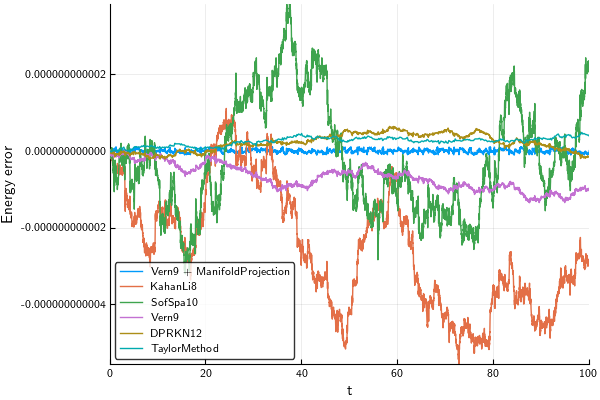

In [4]:
compare(tmax=1e2)

  0.768876 seconds (2.97 M allocations: 443.164 MiB, 44.77% gc time)
  0.242806 seconds (1.90 M allocations: 101.091 MiB, 53.78% gc time)
  0.362040 seconds (1.90 M allocations: 101.091 MiB, 49.25% gc time)
  0.184810 seconds (924.02 k allocations: 102.694 MiB, 59.67% gc time)
  0.031379 seconds (482.62 k allocations: 21.509 MiB)
  2.405719 seconds (18.30 M allocations: 2.589 GiB, 39.51% gc time)
Vern9 + ManifoldProjection max energy error:	9.947598300641403e-14	in	48625	steps.
KahanLi8 max energy error:			1.0530243343964685e-11	in	100002	steps.
SofSpa10 max energy error:			1.5077716852829326e-11	in	100002	steps.
Vern9 max energy error:				5.7838178690872155e-12	in	48622	steps.
DPRKN12 max energy error:			2.2453150450019166e-12	in	18930	steps.
TaylorMethod max energy error:			1.0089706847793423e-12	in	5082	steps.



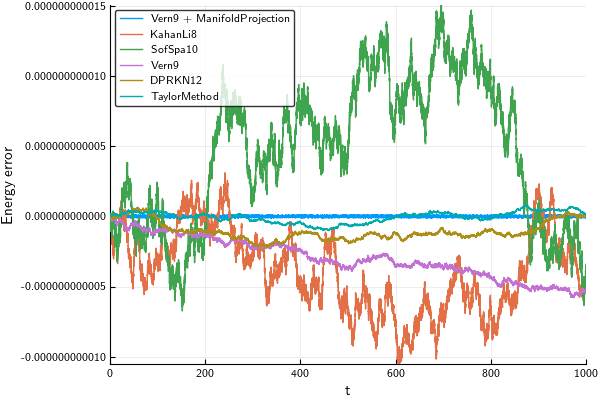

In [5]:
compare(tmax=1e3)

 13.463276 seconds (29.67 M allocations: 4.295 GiB, 68.83% gc time)
  3.457380 seconds (19.00 M allocations: 966.797 MiB, 68.15% gc time)
  6.093005 seconds (19.00 M allocations: 966.798 MiB, 70.35% gc time)
  6.950590 seconds (9.24 M allocations: 1006.654 MiB, 87.05% gc time)
  5.102354 seconds (4.82 M allocations: 206.832 MiB, 93.51% gc time)
 26.807192 seconds (182.98 M allocations: 25.553 GiB, 38.94% gc time)
Vern9 + ManifoldProjection max energy error:	9.947598300641403e-14	in	486198	steps.
KahanLi8 max energy error:			4.3968384488835e-11	in	1000001	steps.
SofSpa10 max energy error:			6.492939519375795e-11	in	1000001	steps.
Vern9 max energy error:				7.524647571699461e-11	in	486166	steps.
DPRKN12 max energy error:			3.673505943879718e-11	in	189205	steps.
TaylorMethod max energy error:			5.073275133327115e-12	in	50814	steps.



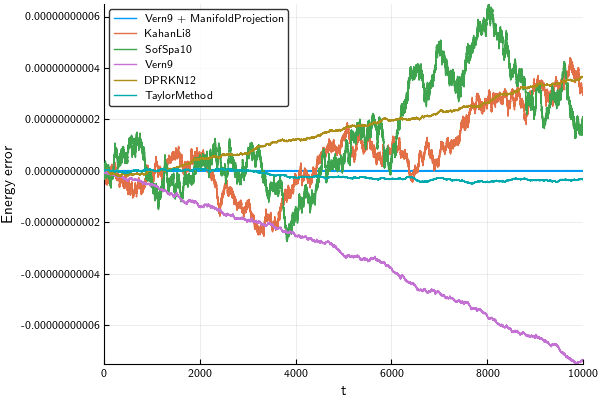

In [6]:
compare(tmax=1e4)

 37.269010 seconds (59.36 M allocations: 8.588 GiB, 76.40% gc time)
  9.738442 seconds (38.00 M allocations: 1.884 GiB, 74.11% gc time)
 17.801549 seconds (38.00 M allocations: 1.884 GiB, 78.37% gc time)
 20.953366 seconds (18.47 M allocations: 1.962 GiB, 91.23% gc time)
  9.660133 seconds (9.64 M allocations: 409.604 MiB, 93.10% gc time)
 62.838802 seconds (365.96 M allocations: 51.068 GiB, 45.58% gc time)
Vern9 + ManifoldProjection max energy error:	9.947598300641403e-14	in	972408	steps.
KahanLi8 max energy error:			1.0363976343796821e-10	in	2000002	steps.
SofSpa10 max energy error:			9.750067420100095e-11	in	2000002	steps.
Vern9 max energy error:				1.4237855339160888e-10	in	972339	steps.
DPRKN12 max energy error:			7.273115443240386e-11	in	378379	steps.
TaylorMethod max energy error:			5.073275133327115e-12	in	101627	steps.



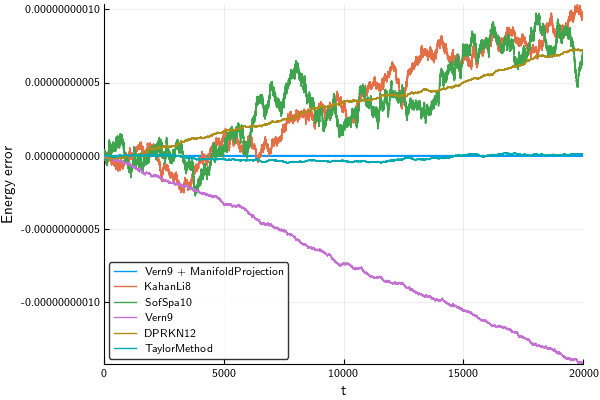

In [7]:
compare(tmax=2e4)

As we can see from the above plots, we can achieve a very low energy error for long time simulation by manifold projection and with very high order Taylor methods. In comparison with the Hénon-Heiles system we see that as the Hamiltonian got more complex, the energy error for the other integration methods increased significantly.

We will now compare the in place with the out of place versions. In the plots bellow we will use a dashed line for the out of place versions.

In [8]:
function in_vs_out(;all=false, tmax=1e2)
    println("In place versions:")
    plt = compare(InPlace, all, tmax=tmax)
    println("\nOut of place versions:")
    plt = compare(OutOfPlace, false, plt; tmax=tmax)
end

in_vs_out (generic function with 1 method)

First, here is a summary of all the available methods for `tmax = 1e3`:

In place versions:
  0.820346 seconds (2.97 M allocations: 443.164 MiB, 45.41% gc time)
  0.265114 seconds (1.90 M allocations: 101.091 MiB, 50.64% gc time)
  0.387876 seconds (1.90 M allocations: 101.091 MiB, 47.30% gc time)
  0.213963 seconds (924.02 k allocations: 102.694 MiB, 54.04% gc time)
  0.034426 seconds (482.62 k allocations: 21.509 MiB)
  2.597814 seconds (18.30 M allocations: 2.589 GiB, 42.16% gc time)
Vern9 + ManifoldProjection max energy error:	9.947598300641403e-14	in	48625	steps.
KahanLi8 max energy error:			1.0530243343964685e-11	in	100002	steps.
SofSpa10 max energy error:			1.5077716852829326e-11	in	100002	steps.
Vern9 max energy error:				5.7838178690872155e-12	in	48622	steps.
DPRKN12 max energy error:			2.2453150450019166e-12	in	18930	steps.
TaylorMethod max energy error:			1.0089706847793423e-12	in	5082	steps.

Out of place versions:
  0.084002 seconds (200.20 k allocations: 26.270 MiB, 5.35% gc time)
  0.144650 seconds (200.20 k allocations: 26.271 MiB, 4.01% gc 


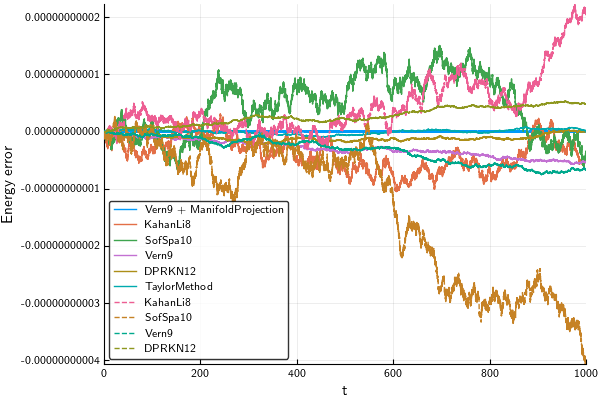

In [10]:
in_vs_out(all=true, tmax=1e3)

Now we will compare the in place and the out of place versions, but only for the integrators that are compatible with `StaticArrays`

In place versions:
  0.011278 seconds (190.21 k allocations: 10.319 MiB)
  0.017460 seconds (190.21 k allocations: 10.319 MiB)
  0.008620 seconds (92.57 k allocations: 10.386 MiB)
  0.003361 seconds (48.75 k allocations: 2.101 MiB)
KahanLi8 max energy error:			5.5706550483591855e-12	in	10001	steps.
SofSpa10 max energy error:			3.836930773104541e-12	in	10001	steps.
Vern9 max energy error:				1.3500311979441904e-12	in	4862	steps.
DPRKN12 max energy error:			6.394884621840902e-13	in	1903	steps.

Out of place versions:
  0.007868 seconds (20.19 k allocations: 3.287 MiB)
  0.013712 seconds (20.19 k allocations: 3.288 MiB)
  0.005621 seconds (9.92 k allocations: 3.867 MiB)
  0.002760 seconds (24.51 k allocations: 1.213 MiB)
KahanLi8 max energy error:			5.229594535194337e-12	in	10001	steps.
SofSpa10 max energy error:			4.007461029686965e-12	in	10001	steps.
Vern9 max energy error:				1.1368683772161603e-12	in	4866	steps.
DPRKN12 max energy error:			9.521272659185342e-13	in	1906	steps.



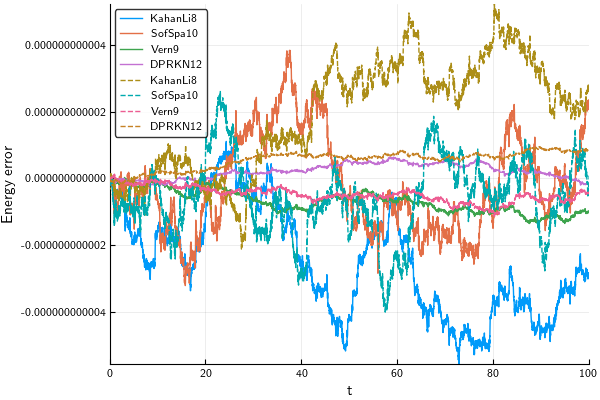

In [11]:
in_vs_out(tmax=1e2)

In place versions:
  0.262127 seconds (1.90 M allocations: 101.091 MiB, 48.84% gc time)
  0.382955 seconds (1.90 M allocations: 101.091 MiB, 45.09% gc time)
  0.204493 seconds (924.02 k allocations: 102.694 MiB, 51.94% gc time)
  0.035137 seconds (482.62 k allocations: 21.509 MiB)
KahanLi8 max energy error:			1.0530243343964685e-11	in	100002	steps.
SofSpa10 max energy error:			1.5077716852829326e-11	in	100002	steps.
Vern9 max energy error:				5.7838178690872155e-12	in	48622	steps.
DPRKN12 max energy error:			2.2453150450019166e-12	in	18930	steps.

Out of place versions:
  0.081920 seconds (200.20 k allocations: 26.270 MiB, 5.78% gc time)
  0.142147 seconds (200.20 k allocations: 26.271 MiB, 4.03% gc time)
  0.058428 seconds (97.44 k allocations: 35.698 MiB, 8.58% gc time)
  0.025098 seconds (240.34 k allocations: 13.194 MiB)
KahanLi8 max energy error:			2.2353674467012752e-11	in	100002	steps.
SofSpa10 max energy error:			4.079936388734495e-11	in	100002	steps.
Vern9 max energy error:			


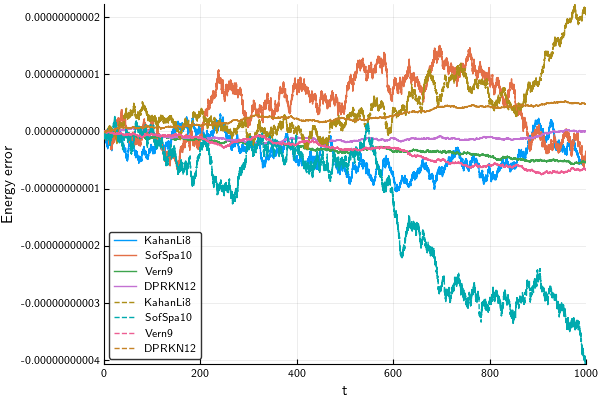

In [12]:
in_vs_out(tmax=1e3)

In place versions:
  2.549649 seconds (19.00 M allocations: 966.797 MiB, 47.80% gc time)
  5.303977 seconds (19.00 M allocations: 966.798 MiB, 60.22% gc time)
  5.907600 seconds (9.24 M allocations: 1006.654 MiB, 83.82% gc time)
  4.474796 seconds (4.82 M allocations: 206.832 MiB, 91.44% gc time)
KahanLi8 max energy error:			4.3968384488835e-11	in	1000001	steps.
SofSpa10 max energy error:			6.492939519375795e-11	in	1000001	steps.
Vern9 max energy error:				7.524647571699461e-11	in	486166	steps.
DPRKN12 max energy error:			3.673505943879718e-11	in	189205	steps.

Out of place versions:
  1.001560 seconds (2.00 M allocations: 208.599 MiB, 22.26% gc time)
  1.834620 seconds (2.00 M allocations: 212.600 MiB, 25.05% gc time)
  1.084412 seconds (972.65 k allocations: 328.785 MiB, 50.40% gc time)
  0.581671 seconds (2.40 M allocations: 114.698 MiB, 55.29% gc time)
KahanLi8 max energy error:			3.595346242946107e-11	in	1000001	steps.
SofSpa10 max energy error:			8.72120153871947e-11	in	1000001	s


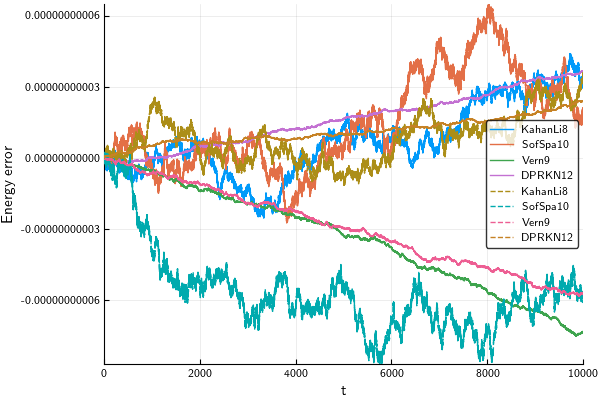

In [13]:
in_vs_out(tmax=1e4)

In place versions:
  6.074960 seconds (38.00 M allocations: 1.884 GiB, 56.33% gc time)
 14.445998 seconds (38.00 M allocations: 1.884 GiB, 71.44% gc time)
 17.011554 seconds (18.47 M allocations: 1.962 GiB, 88.83% gc time)
  8.240489 seconds (9.64 M allocations: 409.604 MiB, 91.12% gc time)
KahanLi8 max energy error:			1.0363976343796821e-10	in	2000002	steps.
SofSpa10 max energy error:			9.750067420100095e-11	in	2000002	steps.
Vern9 max energy error:				1.4237855339160888e-10	in	972339	steps.
DPRKN12 max energy error:			7.273115443240386e-11	in	378379	steps.

Out of place versions:
  1.969388 seconds (4.00 M allocations: 417.187 MiB, 20.85% gc time)
  3.325583 seconds (4.00 M allocations: 421.188 MiB, 17.12% gc time)
  2.120630 seconds (1.95 M allocations: 653.544 MiB, 48.89% gc time)
  1.344800 seconds (4.80 M allocations: 225.369 MiB, 61.47% gc time)
KahanLi8 max energy error:			4.359890226623975e-11	in	2000002	steps.
SofSpa10 max energy error:			8.72120153871947e-11	in	2000002	steps


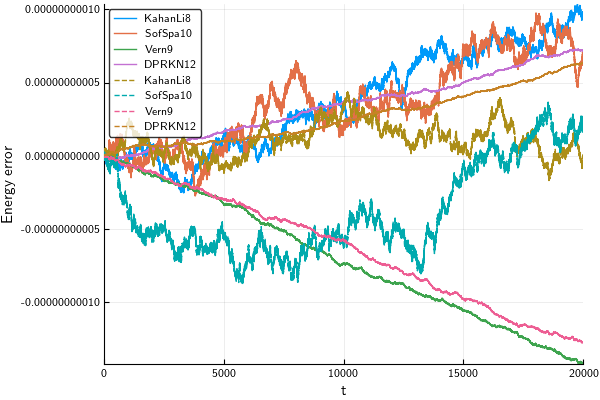

In [14]:
in_vs_out(tmax=2e4)

As we see from the above comparisons, the `StaticArray` versions are significantly faster and use less memory. The speedup provided for the out of place version is more proeminent at larger values for `tmax`.
We can see again that if the simulation time is increased, the energy error of the symplectic methods is less noticeable compared to the rest of the methods.
In comparison with the Henon-Heiles case, we see that the symplectic methods are more competitive with `DPRKN12`.

The benchmarks were performed on a machine with

In [15]:
versioninfo()

Julia Version 0.6.2
Commit d386e40c17 (2017-12-13 18:08 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-4720HQ CPU @ 2.60GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, haswell)
